In [1]:
import torch
from torch.autograd import grad
import torch.nn as nn
from numpy import genfromtxt
import torch.optim as optim
import matplotlib.pyplot as plt
import torch.nn.functional as F

zika_data = genfromtxt('zika.csv', delimiter=',') #in the form of [t, Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv]

torch.manual_seed(1234)

In [2]:
%%time

PATH = 'zika' 

class DINN(nn.Module):
    def __init__(self, t, Sh_data, Eh_data, Ih1_data, Ih2_data, Ah_data, Rh_data, Sv_data, Ev_data, Iv_data):
        super(DINN, self).__init__()
        self.t = torch.tensor(t, requires_grad=True)
        self.t_float = self.t.float()
        self.t_batch = torch.reshape(self.t_float, (len(self.t),1)) #reshape for batch 
        self.Sh = torch.tensor(Sh_data)
        self.Eh = torch.tensor(Eh_data)
        self.Ih1 = torch.tensor(Ih1_data)
        self.Ih2 = torch.tensor(Ih2_data)
        self.Ah = torch.tensor(Ah_data)
        self.Rh = torch.tensor(Rh_data)
        self.Sv = torch.tensor(Sv_data)
        self.Ev = torch.tensor(Ev_data)
        self.Iv = torch.tensor(Iv_data)
        self.Nh = torch.tensor(0.5186280000000001)
        self.Nv = 5 * self.Nh

        self.losses = [] #keep the losses
        self.save = 2 #which file to save to

        #learnable parameters
        self.a_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.5) 
        self.b_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.4)
        self.c_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.5)
        self.eta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.1)
        self.beta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.05)
        self.kappa_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.6)
        self.tao_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(0.3)
        self.theta_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(18)
        self.m_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(5)
        self.V_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/5)
        self.V_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(10)
        self.gamma_h1_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/5)
        self.gamma_h2_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/20)
        self.gamma_h_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/7)
        self.mu_v_tilda = torch.nn.Parameter(torch.rand(1, requires_grad=True)) #torch.tensor(1/14)

        #matrices (x9 for Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv) for the gradients
        self.m1 = torch.zeros((len(self.t), 9)); self.m1[:, 0] = 1
        self.m2 = torch.zeros((len(self.t), 9)); self.m2[:, 1] = 1
        self.m3 = torch.zeros((len(self.t), 9)); self.m3[:, 2] = 1
        self.m4 = torch.zeros((len(self.t), 9)); self.m4[:, 3] = 1
        self.m5 = torch.zeros((len(self.t), 9)); self.m5[:, 4] = 1
        self.m6 = torch.zeros((len(self.t), 9)); self.m6[:, 5] = 1
        self.m7 = torch.zeros((len(self.t), 9)); self.m7[:, 6] = 1
        self.m8 = torch.zeros((len(self.t), 9)); self.m8[:, 7] = 1
        self.m9 = torch.zeros((len(self.t), 9)); self.m9[:, 8] = 1

        #values for norm
        self.Sh_max = max(self.Sh)
        self.Eh_max = max(self.Eh)
        self.Ih1_max = max(self.Ih1)
        self.Ih2_max = max(self.Ih2)
        self.Ah_max = max(self.Ah)
        self.Rh_max = max(self.Rh)
        self.Sv_max = max(self.Sv)
        self.Ev_max = max(self.Ev)
        self.Iv_max = max(self.Iv)
        self.Sh_min = min(self.Sh)
        self.Eh_min = min(self.Eh)
        self.Ih1_min = min(self.Ih1)
        self.Ih2_min = min(self.Ih2)
        self.Ah_min = min(self.Ah)
        self.Rh_min = min(self.Rh)
        self.Sv_min = min(self.Sv)
        self.Ev_min = min(self.Ev)
        self.Iv_min = min(self.Iv)

        #normalize 
        self.Sh_hat = (self.Sh - self.Sh_min)/(self.Sh_max - self.Sh_min)
        self.Eh_hat = (self.Eh - self.Eh_min)/(self.Eh_max - self.Eh_min)
        self.Ih1_hat = (self.Ih1 - self.Ih1_min)/(self.Ih1_max - self.Ih1_min)
        self.Ih2_hat = (self.Ih2 - self.Ih2_min)/(self.Ih2_max - self.Ih2_min)
        self.Ah_hat = (self.Ah - self.Ah_min)/(self.Ah_max - self.Ah_min)
        self.Rh_hat = (self.Rh - self.Rh_min)/(self.Rh_max - self.Rh_min)
        self.Sv_hat = (self.Sv - self.Sv_min)/(self.Sv_max - self.Sv_min)
        self.Ev_hat = (self.Ev - self.Ev_min)/(self.Ev_max - self.Ev_min)
        self.Iv_hat = (self.Iv - self.Iv_min)/(self.Iv_max - self.Iv_min)

        #NN
        self.net_zika = self.Net_zika()
        self.params = list(self.net_zika.parameters())
        self.params.extend(list([self.a_tilda, self.b_tilda, self.c_tilda, self.eta_tilda, self.beta_tilda, self.kappa_tilda, self.tao_tilda, self.theta_tilda, self.m_tilda, self.V_h_tilda, self.V_v_tilda, self.gamma_h1_tilda, self.gamma_h2_tilda, self.gamma_h_tilda, self.mu_v_tilda]))


    #force parameters to be in a range
    @property 
    def a(self):
        return torch.tanh(self.a_tilda) * 0.01  + 0.5

    @property 
    def b(self):
        return torch.tanh(self.b_tilda) * 0.01  + 0.4

    @property 
    def c(self):
        return torch.tanh(self.c_tilda) * 0.01  + 0.5

    @property 
    def eta(self):
        return torch.tanh(self.eta_tilda) * 0.01  + 0.1

    @property 
    def beta(self):
        return torch.tanh(self.beta_tilda) * 0.0005 + 0.05

    @property 
    def kappa(self):
        return torch.tanh(self.kappa_tilda) * 0.006  + 0.6

    @property 
    def tao(self):
        return torch.tanh(self.tao_tilda) * 0.03  + 0.3

    @property 
    def theta(self):
        return torch.tanh(self.theta_tilda) * 0.2  + 18

    @property 
    def m(self):
        return torch.tanh(self.m_tilda) * 0.5 + 5

    @property 
    def V_h(self):
        return torch.tanh(self.V_h_tilda) * 0.002 + 0.2

    @property 
    def V_v(self):
        return torch.tanh(self.V_v_tilda) * 0.1  + 10

    @property 
    def gamma_h1(self):
        return torch.tanh(self.gamma_h1_tilda) * 0.02 + 0.2

    @property 
    def gamma_h2(self):
        return torch.tanh(self.gamma_h2_tilda) * 0.0005 + 0.05

    @property 
    def gamma_h(self):
        return torch.tanh(self.gamma_h_tilda) * 0.001 + 0.14

    @property 
    def mu_v(self):
        return torch.tanh(self.mu_v_tilda) * 0.007 + 0.07


    #nets
    class Net_zika(nn.Module): # input = [t]
        def __init__(self):
            super(DINN.Net_zika, self).__init__()
            self.fc1=nn.Linear(1, 20) #takes 100 t's
            self.fc2=nn.Linear(20, 20)
            self.fc3=nn.Linear(20, 20)
            self.fc4=nn.Linear(20, 20)
            self.fc5=nn.Linear(20, 20)
            self.fc6=nn.Linear(20, 20)
            self.fc7=nn.Linear(20, 20)
            self.fc8=nn.Linear(20, 20)
            self.out=nn.Linear(20, 9) #outputs Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv

        def forward(self, t):
            zika=F.relu(self.fc1(t))
            zika=F.relu(self.fc2(zika))
            zika=F.relu(self.fc3(zika))
            zika=F.relu(self.fc4(zika))
            zika=F.relu(self.fc5(zika))
            zika=F.relu(self.fc6(zika))
            zika=F.relu(self.fc7(zika))
            zika=F.relu(self.fc8(zika))
            zika=self.out(zika)
            return zika    

    def net_f(self, t_batch):       

        zika_hat = self.net_zika(t_batch)

        Sh_hat, Eh_hat, Ih1_hat, Ih2_hat, Ah_hat, Rh_hat, Sv_hat, Ev_hat, Iv_hat = zika_hat[:,0], zika_hat[:,1], zika_hat[:,2], zika_hat[:,3], zika_hat[:,4], zika_hat[:,5], zika_hat[:,6], zika_hat[:,7], zika_hat[:,8]

        #Sh_hat
        zika_hat.backward(self.m1, retain_graph=True)
        Sh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Eh_hat
        zika_hat.backward(self.m2, retain_graph=True)
        Eh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ih1_hat
        zika_hat.backward(self.m3, retain_graph=True)
        Ih1_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ih2_hat
        zika_hat.backward(self.m4, retain_graph=True)
        Ih2_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ah_hat
        zika_hat.backward(self.m5, retain_graph=True)
        Ah_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Rh_hat
        zika_hat.backward(self.m6, retain_graph=True)
        Rh_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Sv_hat
        zika_hat.backward(self.m7, retain_graph=True)
        Sv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Ev_hat
        zika_hat.backward(self.m8, retain_graph=True)
        Ev_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #Iv_hat
        zika_hat.backward(self.m9, retain_graph=True)
        Iv_hat_t = self.t.grad.clone()
        self.t.grad.zero_()

        #unnormalize
        Sh = self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat
        Eh = self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat
        Ih1 = self.Ih1_min + (self.Ih1_max - self.Ih1_min) * Ih1_hat
        Ih2 =  self.Ih2_min + (self.Ih2_max - self.Ih2_min) * Ih2_hat
        Ah = self.Ah_min + (self.Ah_max - self.Ah_min) * Ah_hat
        Rh = self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat
        Sv = self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat
        Ev = self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat
        Iv = self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat
        
        #equations
        f1_hat = Sh_hat_t - (-self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + self.Ih1 + self.tao * Ih2) / self.Nh ) * Sh) / (self.Sh_max - self.Sh_min) 
        f2_hat = Eh_hat_t - (self.theta * (-self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + Ih1 + self.tao * Ih2) / self.Nh ) * Sh) - self.V_h * Eh) / (self.Eh_max - self.Eh_min) 
        f3_hat = Ih1_hat_t - (self.V_h * Eh - self.gamma_h1 * Ih1) / (self.Ih1_max - self.Ih1_min) 
        f4_hat = Ih2_hat_t - (self.gamma_h1 * Ih1 - self.gamma_h2 * Ih2) / (self.Ih2_max - self.Ih2_min) 
        f5_hat = Ah_hat_t - ((1 - self.theta) * (self.a * self.b * (Iv/self.Nh) * Sh - self.beta * ((self.kappa * Eh + Ih1 + self.tao * Ih2) / self.Nh ) * Sh) - self.gamma_h * Ah) / (self.Ah_max - self.Ah_min) 
        f6_hat = Rh_hat_t - (self.gamma_h2 * Ih2 + self.gamma_h * Ah) / (self.Rh_max - self.Rh_min) 
        f7_hat = Sv_hat_t - (self.mu_v * self.Nv - self.a * self.c * ((self.eta * Eh + Ih1)/self.Nh) * Sv - self.mu_v * Sv) / (self.Sv_max - self.Sv_min) 
        f8_hat = Ev_hat_t - (self.a * self.c * ((self.eta * Eh + Ih1)/self.Nh) - (self.V_v + self.mu_v) * Ev) / (self.Ev_max - self.Ev_min) 
        f9_hat = Iv_hat_t - (self.V_v * Ev - self.mu_v * Iv) / (self.Iv_max - self.Iv_min) 

        return f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, Sh_hat, Eh_hat, Ih1_hat, Ih2_hat, Ah_hat, Rh_hat, Sv_hat, Ev_hat, Iv_hat
    
    def load(self):
      # Load checkpoint
      try:
        checkpoint = torch.load(PATH + str(self.save)+'.pt') 
        print('\nloading pre-trained model...')
        self.load_state_dict(checkpoint['model'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.scheduler.load_state_dict(checkpoint['scheduler'])
        epoch = checkpoint['epoch']
        loss = checkpoint['loss']
        self.losses = checkpoint['losses']
        print('loaded previous loss: ', loss)

      except RuntimeError :
          print('changed the architecture, ignore')
          pass
      except FileNotFoundError:
          pass

    def train(self, n_epochs):
      #try loading
      self.load()

      #train
      print('\nstarting training...\n')
      
      for epoch in range(n_epochs):
        #lists to hold the output (maintain only the final epoch)
        Sh_pred_list = []
        Eh_pred_list = []
        Ih1_pred_list = []
        Ih2_pred_list = []
        Ah_pred_list = []
        Rh_pred_list = []
        Sv_pred_list = []
        Ev_pred_list = []
        Iv_pred_list = []

        f1_hat, f2_hat, f3_hat, f4_hat, f5_hat, f6_hat, f7_hat, f8_hat, f9_hat, Sh_hat_pred, Eh_hat_pred, Ih1_hat_pred, Ih2_hat_pred, Ah_hat_pred, Rh_hat_pred, Sv_hat_pred, Ev_hat_pred, Iv_hat_pred = self.net_f(self.t_batch)
        self.optimizer.zero_grad()

        Sh_pred_list.append(self.Sh_min + (self.Sh_max - self.Sh_min) * Sh_hat_pred)
        Eh_pred_list.append(self.Eh_min + (self.Eh_max - self.Eh_min) * Eh_hat_pred)
        Ih1_pred_list.append(self.Ih1_min + (self.Ih1_max - self.Ih1_min) * Ih1_hat_pred)
        Ih2_pred_list.append(self.Ih2_min + (self.Ih2_max - self.Ih2_min) * Ih2_hat_pred)
        Ah_pred_list.append(self.Ah_min + (self.Ah_max - self.Ah_min) * Ah_hat_pred)
        Rh_pred_list.append(self.Rh_min + (self.Rh_max - self.Rh_min) * Rh_hat_pred)
        Sv_pred_list.append(self.Sv_min + (self.Sv_max - self.Sv_min) * Sv_hat_pred)
        Ev_pred_list.append(self.Ev_min + (self.Ev_max - self.Ev_min) * Ev_hat_pred)
        Iv_pred_list.append(self.Iv_min + (self.Iv_max - self.Iv_min) * Iv_hat_pred)

        loss = (
              torch.mean(torch.square(self.Sh_hat - Sh_hat_pred)) + torch.mean(torch.square(self.Eh_hat - Eh_hat_pred)) + 
              torch.mean(torch.square(self.Ih1_hat - Ih1_hat_pred)) + torch.mean(torch.square(self.Ih2_hat - Ih2_hat_pred)) + 
              torch.mean(torch.square(self.Ah_hat - Ah_hat_pred)) + torch.mean(torch.square(self.Rh_hat - Rh_hat_pred)) + 
              torch.mean(torch.square(self.Sv_hat - Sv_hat_pred)) + torch.mean(torch.square(self.Ev_hat - Ev_hat_pred)) + 
              torch.mean(torch.square(self.Iv_hat - Iv_hat_pred)) +
              torch.mean(torch.square(f1_hat)) + torch.mean(torch.square(f2_hat)) +
              torch.mean(torch.square(f3_hat)) + torch.mean(torch.square(f4_hat)) +
              torch.mean(torch.square(f5_hat)) + torch.mean(torch.square(f6_hat)) +
              torch.mean(torch.square(f7_hat)) + torch.mean(torch.square(f8_hat)) +
              torch.mean(torch.square(f9_hat))
               )

        loss.backward()

        self.optimizer.step()
        # self.scheduler.step() 
        self.scheduler.step(loss) 
        
        self.losses.append(loss.item())

        if epoch % 1000 == 0:          
          print('\nEpoch ', epoch)

        #loss + model parameters update
        if epoch % 4000 == 99999:
          #checkpoint save every 1000 epochs if the loss is lower
          print('\nSaving model... Loss is: ', loss)
          torch.save({
              'epoch': epoch,
              'model': self.state_dict(),
              'optimizer_state_dict': self.optimizer.state_dict(),
              'scheduler': self.scheduler.state_dict(),
              'loss': loss,
              'losses': self.losses,
              }, PATH + str(self.save)+'.pt')
          if self.save % 2 > 0: #its on 3
            self.save = 2 #change to 2
          else: #its on 2
            self.save = 3 #change to 3

          print('epoch: ', epoch)
          # print('alpha1: (goal 1)', self.alpha1)
          # print('\nalpha2: (goal 0)', self.alpha2)
          # print('\nbeta: (goal 0.0075): ', self.beta)
          # print('\nmu (goal 5): ', self.mu)
          # print('\nu: (goal 0.515151515): ', self.u)
          # print('\ntao (goal 0.58): ', self.tao)
          print('#################################')
        
      #plot
      plt.plot(self.losses, color = 'teal')
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      return Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list

CPU times: user 89 µs, sys: 2 µs, total: 91 µs
Wall time: 95.8 µs



loading pre-trained model...
loaded previous loss:  tensor(0.0380, dtype=torch.float64, requires_grad=True)

starting training...


Epoch  0


/Users/sagishaier/anaconda3/envs/dinn/lib/python3.6/site-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


CPU times: user 1.81 s, sys: 314 ms, total: 2.12 s
Wall time: 2.13 s


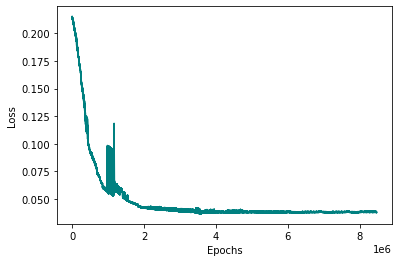

In [3]:
%%time

#this worked best
dinn = DINN(zika_data[0], zika_data[1], zika_data[2], zika_data[3], zika_data[4], zika_data[5], zika_data[6], zika_data[7], zika_data[8], zika_data[9]) #t, S_data, I_data

learning_rate = 1e-3
optimizer = optim.Adam(dinn.params, lr = learning_rate)
dinn.optimizer = optimizer

#scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(dinn.optimizer, factor=0.85, patience = 5000, verbose=True)
#scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-6, max_lr=1e-3, step_size_up=100, mode="triangular2", cycle_momentum=False)
scheduler = torch.optim.lr_scheduler.CyclicLR(dinn.optimizer, base_lr=1e-9, max_lr=1e-3, step_size_up=1000, mode="exp_range", gamma=0.85, cycle_momentum=False)

dinn.scheduler = scheduler

try: 
  Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
except EOFError:
  if dinn.save == 2:
    dinn.save = 3
    Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train
  elif dinn.save == 3:
    dinn.save = 2
    Sh_pred_list, Eh_pred_list, Ih1_pred_list, Ih2_pred_list, Ah_pred_list, Rh_pred_list, Sv_pred_list, Ev_pred_list, Iv_pred_list = dinn.train(1) #train

Text(0, 0.5, 'Loss')

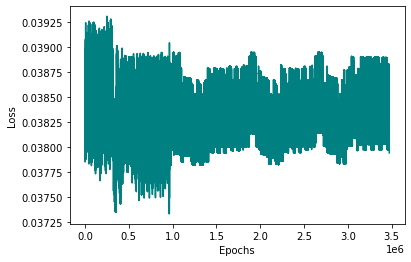

In [4]:
plt.plot(dinn.losses[5000000:], color = 'teal')
plt.xlabel('Epochs')
plt.ylabel('Loss')

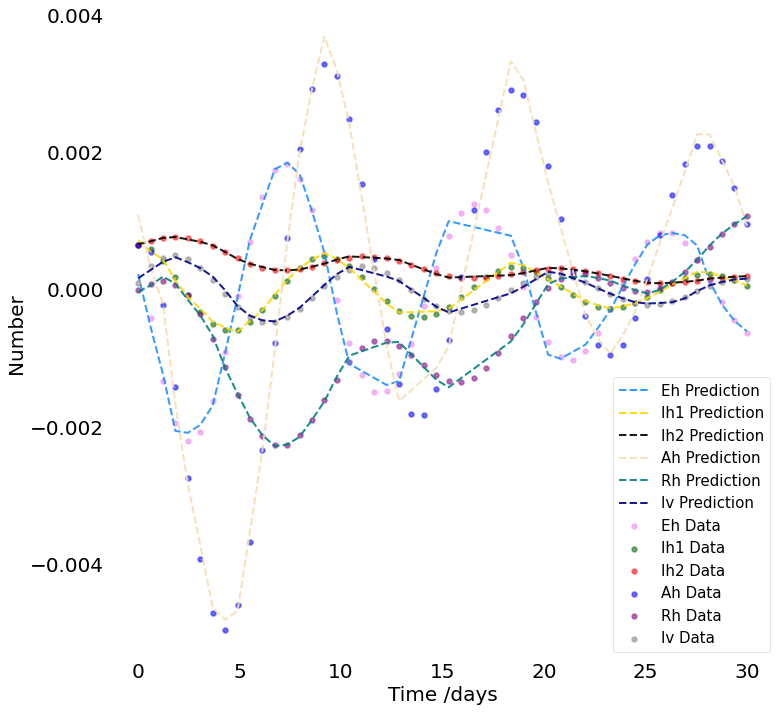

In [8]:
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# ax.scatter(zika_data[0], zika_data[1], color =  'pink', alpha=0.5, lw=2, label='Sh Data',s=20)
# ax.plot(zika_data[0], Sh_pred_list[0].detach().numpy(), 'navy', alpha=0.9, lw=2, label='Sh Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[2], color =  'violet', alpha=0.5, lw=2, label='Eh Data',s=20)
ax.plot(zika_data[0], Eh_pred_list[0].detach().numpy(), 'dodgerblue', alpha=0.9, lw=2, label='Eh Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[3], color =  'darkgreen', alpha=0.5, lw=2, label='Ih1 Data',s=20)
ax.plot(zika_data[0], Ih1_pred_list[0].detach().numpy(), 'gold', alpha=0.9, lw=2, label='Ih1 Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[4], color =  'red', alpha=0.5, lw=2, label='Ih2 Data',s=20)
ax.plot(zika_data[0], Ih2_pred_list[0].detach().numpy(), 'black', alpha=0.9, lw=2, label='Ih2 Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[5], color =  'blue', alpha=0.5, lw=2, label='Ah Data',s=20)
ax.plot(zika_data[0], Ah_pred_list[0].detach().numpy(), 'wheat', alpha=0.9, lw=2, label='Ah Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[6], color =  'purple', alpha=0.5, lw=2, label='Rh Data',s=20)
ax.plot(zika_data[0], Rh_pred_list[0].detach().numpy(), 'teal', alpha=0.9, lw=2, label='Rh Prediction', linestyle='dashed')

# ax.scatter(zika_data[0], zika_data[7], color =  'yellow', alpha=0.5, lw=2, label='Sv Data',s=20)
# ax.plot(zika_data[0], Sv_pred_list[0].detach().numpy(), 'slategrey', alpha=0.9, lw=2, label='Sv Prediction', linestyle='dashed')

# ax.scatter(zika_data[0], zika_data[8], color =  'black', alpha=0.5, lw=2, label='Ev Data',s=20)
# ax.plot(zika_data[0], Ev_pred_list[0].detach().numpy(), 'aqua', alpha=0.9, lw=2, label='Ev Prediction', linestyle='dashed')

ax.scatter(zika_data[0], zika_data[9], color =  'grey', alpha=0.5, lw=2, label='Iv Data',s=20)
ax.plot(zika_data[0], Iv_pred_list[0].detach().numpy(), 'darkblue', alpha=0.9, lw=2, label='Iv Prediction', linestyle='dashed')


ax.set_xlabel('Time /days',size = 20)
ax.set_ylabel('Number',size = 20)
#ax.set_ylim([-1,50])
ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
plt.xticks(size = 20)
plt.yticks(size = 20)
# ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend(prop={'size':15})
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.savefig('zika.pdf')
plt.show()

tensor([0.1991], grad_fn=<AddBackward0>)
tensor([0.0504], grad_fn=<AddBackward0>)


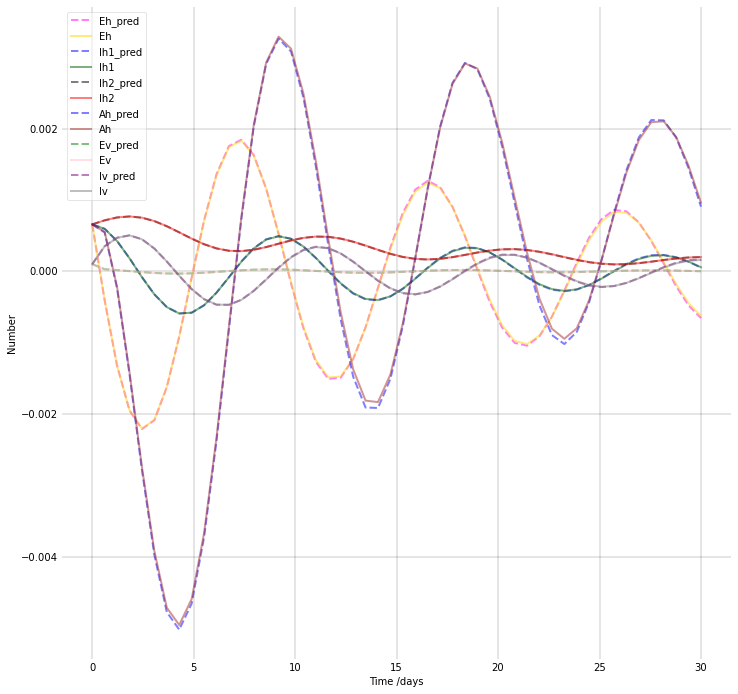

In [6]:
#vaccination! 

import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

# Initial conditions
Sh0 = 0.516
Eh0 = 0.000657
Ih10 = 0.000657
Ih20 = 0.000657
Ah0 = 0.000657
Rh0 = 0
Nh = Sh0 + Eh0 + Ih10 + Ih20 + Ah0 + Rh0
Nv = 5 * Nh
Sv0 = 1e-4
Ev0 = 1e-4
Iv0 =  1e-4

# A grid of time points (in days)
t = np.linspace(0, 30, 50) 

#parameters
a = dinn.a
b = dinn.b
c = dinn.c
eta = dinn.eta
beta = dinn.beta
kappa = dinn.kappa
tao = dinn.tao
theta = dinn.theta
m = dinn.m
V_h = dinn.V_h
V_v = dinn.V_v
gamma_h1 = dinn.gamma_h1
gamma_h2 = dinn.gamma_h2
gamma_h = dinn.gamma_h
mu_v = dinn.mu_v



print(dinn.gamma_h1)
print(dinn.gamma_h2)
# The SIR model differential equations.
def deriv(y, t,Nh, a, b, c, eta, beta, kappa, tao, theta, m, V_h, V_v, gamma_h1, gamma_h2, gamma_h, mu_v):
    Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv = y
    dShdt = -a * b * (Iv/Nh) * Sh - beta * ((kappa * Eh + Ih1 + tao * Ih2) / Nh ) * Sh
    dEhdt = theta * (-a * b * (Iv/Nh) * Sh - beta * ((kappa * Eh + Ih1 + tao * Ih2) / Nh ) * Sh) - V_h * Eh
    dIh1dt = V_h * Eh - gamma_h1 * Ih1
    dIh2dt = gamma_h1 * Ih1 - gamma_h2 * Ih2
    dAhdt = (1 - theta) * (a * b * (Iv/Nh) * Sh - beta * ((kappa * Eh + Ih1 + tao * Ih2) / Nh ) * Sh) - gamma_h * Ah
    dRhdt = gamma_h2 * Ih2 + gamma_h * Ah
    dSvdt = mu_v * Nv - a * c * ((eta * Eh + Ih1)/Nh) * Sv - mu_v * Sv
    dEvdt = a * c * ((eta * Eh + Ih1)/Nh) - (V_v + mu_v) * Ev
    dIvdt = V_v * Ev - mu_v * Iv

    return dShdt, dEhdt, dIh1dt, dIh2dt, dAhdt, dRhdt, dSvdt, dEvdt, dIvdt


# Initial conditions vector
y0 = Sh0, Eh0, Ih10, Ih20, Ah0, Rh0, Sv0, Ev0, Iv0
# Integrate the SIR equations over the time grid, t.
ret = odeint(deriv, y0, t, args=(Nh, a, b, c, eta, beta, kappa, tao, theta, m, V_h, V_v, gamma_h1, gamma_h2, gamma_h, mu_v))
Sh, Eh, Ih1, Ih2, Ah, Rh, Sv, Ev, Iv = ret.T


# Plot the data on two separate curves for S(t), I(t)
fig = plt.figure(figsize=(12,12))

ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
ax.set_facecolor('xkcd:white')

# ax.plot(t, Sh, 'violet', alpha=0.5, lw=2, label='Sh_pred', linestyle='dashed')
# ax.plot(zika_data[0], zika_data[1], 'pink', alpha=0.5, lw=2, label='Sh')

ax.plot(t, Eh, 'fuchsia', alpha=0.5, lw=2, label='Eh_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[2], 'gold', alpha=0.5, lw=2, label='Eh')

ax.plot(t, Ih1, 'blue', alpha=0.5, lw=2, label='Ih1_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[3], 'darkgreen', alpha=0.5, lw=2, label='Ih1')

ax.plot(t, Ih2, 'black', alpha=0.5, lw=2, label='Ih2_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[4], 'red', alpha=0.5, lw=2, label='Ih2')

ax.plot(t, Ah, 'blue', alpha=0.5, lw=2, label='Ah_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[5], 'brown', alpha=0.5, lw=2, label='Ah')

# ax.plot(t, Rh, 'teal', alpha=0.5, lw=2, label='Rh_pred', linestyle='dashed')
# ax.plot(zika_data[0], zika_data[6], 'purple', alpha=0.5, lw=2, label='Rh')

# ax.plot(t, Sv, 'black', alpha=0.5, lw=2, label='Sv_pred', linestyle='dashed')
# ax.plot(zika_data[0], zika_data[7], 'yellow', alpha=0.5, lw=2, label='Sv')

ax.plot(t, Ev, 'green', alpha=0.5, lw=2, label='Ev_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[8], 'pink', alpha=0.5, lw=2, label='Ev')

ax.plot(t, Iv, 'purple', alpha=0.5, lw=2, label='Iv_pred', linestyle='dashed')
ax.plot(zika_data[0], zika_data[9], 'grey', alpha=0.5, lw=2, label='Iv')

ax.set_xlabel('Time /days')
ax.set_ylabel('Number')

ax.yaxis.set_tick_params(length=0)
ax.xaxis.set_tick_params(length=0)
ax.grid(b=True, which='major', c='black', lw=0.2, ls='-')
legend = ax.legend()
legend.get_frame().set_alpha(0.5)
for spine in ('top', 'right', 'bottom', 'left'):
    ax.spines[spine].set_visible(False)
plt.show()

In [7]:
#calculate relative MSE loss
import math

Sh_total_loss =  0
Sh_den = 0
Eh_total_loss = 0
Eh_den = 0
Ih1_total_loss = 0
Ih1_den = 0
Ih2_total_loss = 0
Ih2_den = 0
Ah_total_loss = 0
Ah_den = 0
Rh_total_loss = 0
Rh_den = 0
Sv_total_loss = 0
Sv_den = 0
Ev_total_loss = 0
Ev_den = 0
Iv_total_loss = 0
Iv_den = 0

for timestep in range(len(t)):
    Sh_value =  zika_data[1][timestep] - Sh[timestep]
    Sh_total_loss += Sh_value**2
    Sh_den += (zika_data[1][timestep])**2
    
    Eh_value = zika_data[2][timestep] - Eh[timestep]
    Eh_total_loss += Eh_value**2
    Eh_den += (zika_data[2][timestep])**2
    
    Ih1_value = zika_data[3][timestep] - Ih1[timestep]
    Ih1_total_loss += Ih1_value**2
    Ih1_den += (zika_data[3][timestep])**2
    
    Ih2_value = zika_data[4][timestep] - Ih2[timestep]
    Ih2_total_loss += Ih2_value**2
    Ih2_den += (zika_data[4][timestep])**2
    
    Ah_value = zika_data[5][timestep] - Ah[timestep]
    Ah_total_loss += Ah_value**2
    Ah_den += (zika_data[5][timestep])**2
    
    Rh_value = zika_data[6][timestep] - Rh[timestep]
    Rh_total_loss += Rh_value**2
    Rh_den += (zika_data[6][timestep])**2
    
    Sv_value = zika_data[7][timestep] - Sv[timestep]
    Sv_total_loss += Sv_value**2
    Sv_den += (zika_data[7][timestep])**2
    
    Ev_value = zika_data[8][timestep] - Ev[timestep]
    Ev_total_loss += Ev_value**2
    Ev_den += (zika_data[8][timestep])**2
    
    Iv_value = zika_data[9][timestep] - Iv[timestep]
    Iv_total_loss += Iv_value**2
    Iv_den += (zika_data[9][timestep])**2

Sh_total_loss =  math.sqrt(Sh_total_loss/Sh_den)
Eh_total_loss = math.sqrt(Eh_total_loss/Eh_den)
Ih1_total_loss = math.sqrt(Ih1_total_loss/Ih1_den)
Ih2_total_loss = math.sqrt(Ih2_total_loss/Ih2_den)
Ah_total_loss = math.sqrt(Ah_total_loss/Ah_den)
Rh_total_loss = math.sqrt(Rh_total_loss/Rh_den)
Sv_total_loss = math.sqrt(Sv_total_loss/Sv_den)
Ev_total_loss = math.sqrt(Ev_total_loss/Ev_den)
Iv_total_loss = math.sqrt(Iv_total_loss/Iv_den)    

print('Sh_total_loss: ', Sh_total_loss)
print('Eh_total_loss: ', Eh_total_loss)
print('Ih1_total_loss: ', Ih1_total_loss)
print('Ih2_total_loss: ', Ih2_total_loss)
print('Ah_total_loss: ', Ah_total_loss)
print('Rh_total_loss: ', Rh_total_loss)
print('Sv_total_loss: ', Sv_total_loss)
print('Ev_total_loss: ', Ev_total_loss)
print('Iv_total_loss: ', Iv_total_loss)

Sh_total_loss:  2.2143234887893464e-06
Eh_total_loss:  0.01764493214452156
Ih1_total_loss:  0.014663391457675184
Ih2_total_loss:  0.003996182960547362
Ah_total_loss:  0.02467117777543553
Rh_total_loss:  0.09122074838014524
Sv_total_loss:  0.005586145371295334
Ev_total_loss:  0.012305322507978564
Iv_total_loss:  0.01814757930249137
